### Import neccessary Libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from dateutil import parser
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


###  Load the dataset

In [12]:
url = "C:/Users/Vaibhav/Desktop/Project3/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(url, encoding='latin-1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])

### Display dataset information

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Modifying data

In [17]:
# Function to handle unknown timezones
def tzinfos(tzname, tzoffset, tzinfo):
    if tzname == 'PDT':
        # Provide information about PDT (Pacific Daylight Time)
        return tzinfo
    else:
        return None

# Apply the modified tzinfos function
df['date'] = df['date'].apply(lambda x: parser.parse(str(x), tzinfos=lambda x, y: tzinfos(x, y, tzinfo=None)) if pd.notnull(x) else x)

df.head()

,target,ids,date,flag,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Data Cleaning

In [21]:
# Removing rows with missing values,having duplicate entries or irrelevant columns
df = df.dropna()


df = df.drop_duplicates()

columns_to_drop = ['ids', 'flag', 'user']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Display information after data cleaning
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599579 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype                              
---  ------        --------------    -----                              
 0   target        1599579 non-null  int64                              
 1   date          1599579 non-null  datetime64[ns, America/Los_Angeles]
 2   text          1599579 non-null  object                             
 3   tweet_length  1599579 non-null  int64                              
 4   month         1599579 non-null  object                             
dtypes: datetime64[ns, America/Los_Angeles](1), int64(2), object(2)
memory usage: 73.2+ MB


###  Visualize sentiment distribution

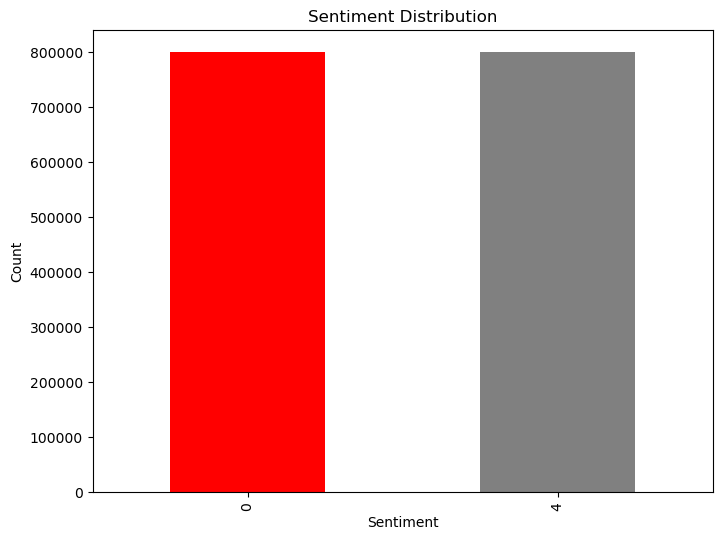

In [22]:
plt.figure(figsize=(8, 6))
df['target'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


### Install required packages

In [6]:
!pip install wordcloud
import sys
print(sys.version)
!pip freeze

3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
aiobotocore @ file:///C:/b/abs_74o47svlua/croot/aiobotocore_1680004300264/work
aiofiles @ file:///C:/b/abs_9ex6mi6b56/croot/aiofiles_1683773603390/work
aiohttp @ file:///C:/ci_311/aiohttp_1676432932774/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///C:/b/abs_9djc_0pyi3/croot/aiosqlite_1683773915844/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-catalogs @ file:///C:/b/abs_8btyy0o8s8/croot/anaconda-catalogs_1685727315626/work
anaconda-client==1.11.3
anaconda-navigator==2.4.2
anaconda-project @ file:///C:/ci_311/anaconda-project_1676458365912/work
anyio @ file:///C:/ci_311/anyio_1676425491996/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci_311/argon2-cffi-b

### Word clouds for positive and negative sentiments

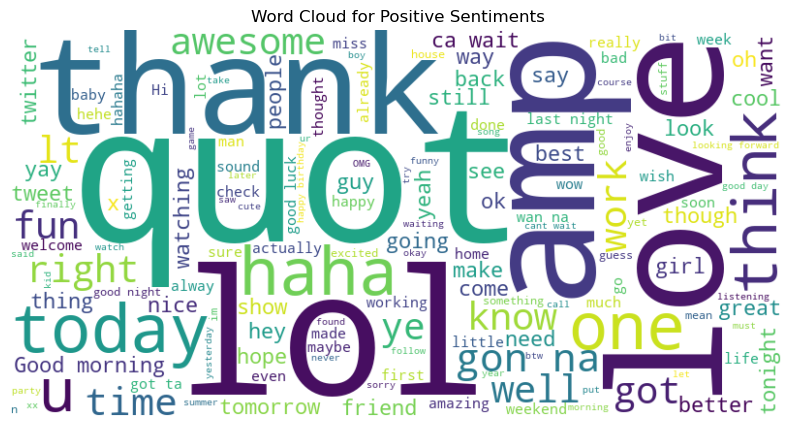

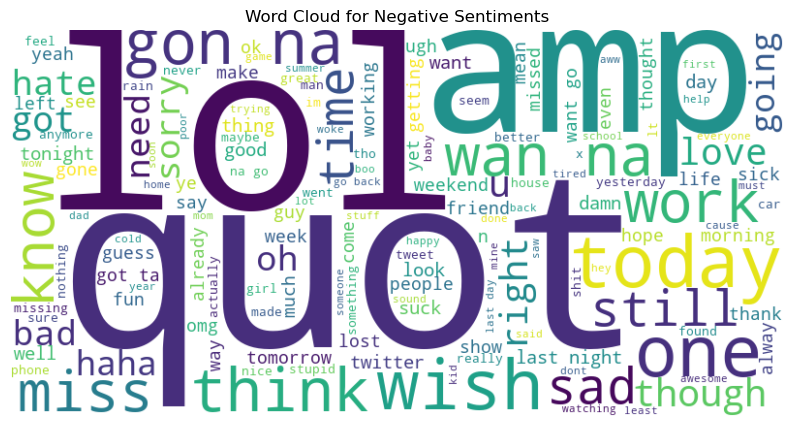

In [26]:
# Separate dataset for positive and negative sentiments
positive_tweets = df[df['target'] == 4]['text']
negative_tweets = df[df['target'] == 0]['text']


# Generate word cloud for positive sentiments
positive_wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(positive_tweets))
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiments')
plt.axis('off')
plt.show()

# Generate word cloud for negative sentiments
negative_wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(negative_tweets))
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiments')
plt.axis('off')
plt.show()

### Visualize sentiment distribution monthly

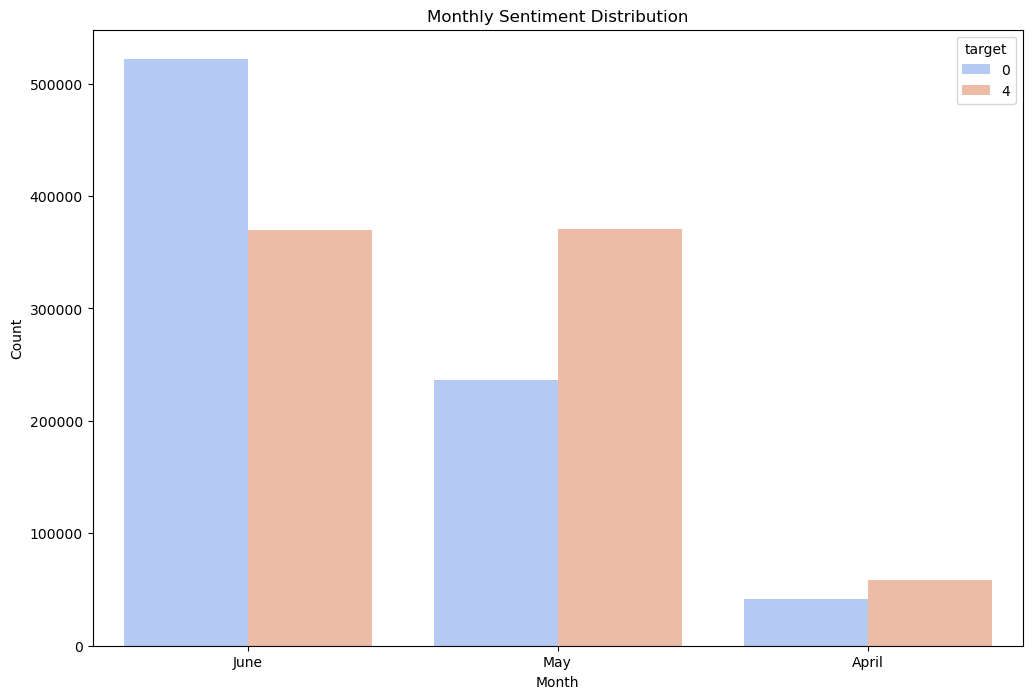

In [29]:
# Visualize sentiment distribution on monthly basis

df['month'] = df['date'].dt.month_name()

plt.figure(figsize=(12, 8))
sns.countplot(x='month', hue='target', data=df, palette='coolwarm', order=df['month'].value_counts().index)
plt.title('Monthly Sentiment Distribution')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Data cleaning - Remove stop words, special characters, and URLs

In [30]:
# for removing stopwords in the text
nltk.download('stopwords')
# for tokenization of the text 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaibhav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vaibhav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vaibhav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Text preprocessing: Remove stop words, special characters, and URLs

### Tokenizing of words

In [31]:
# Removing the stopwords(like, is,the ,are ,etc.) from the tokenize text 
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.isalnum() and word.lower() not in stop_words]))

### Lemmatizing of words

In [32]:
# Lemmatization or reducing words to their base or root form, considering the context and meaning of the words.
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))


### Calculate and visualizing the length of each tweet

In [33]:
df['tweet_length'] = df['text'].apply(len)

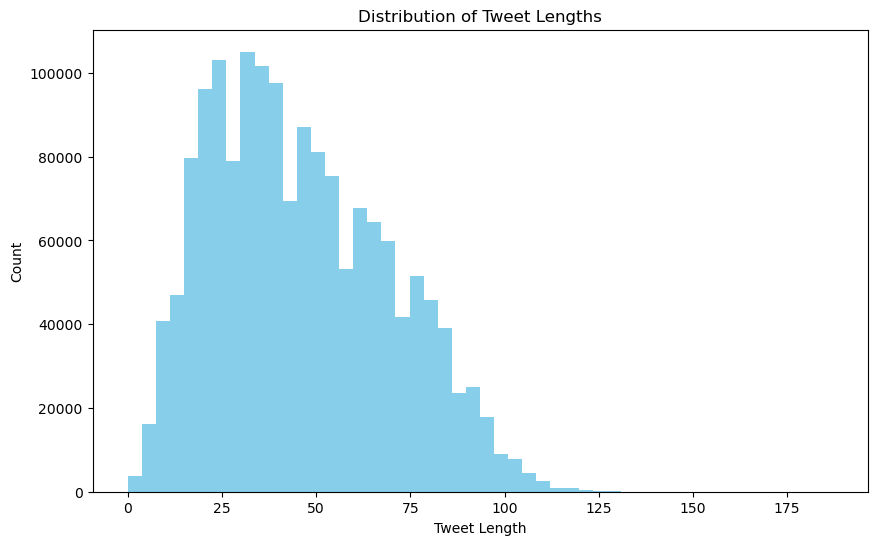

In [34]:
# Histogram showing count of tweets with certain length 
plt.figure(figsize=(10, 6))
df['tweet_length'].plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

### Word frequency analysis

In [35]:
# Tokenizing the words back again
tokenized_words = ' '.join(df['text']).split()
word_counts = Counter(tokenized_words)

### Visualize the most common words

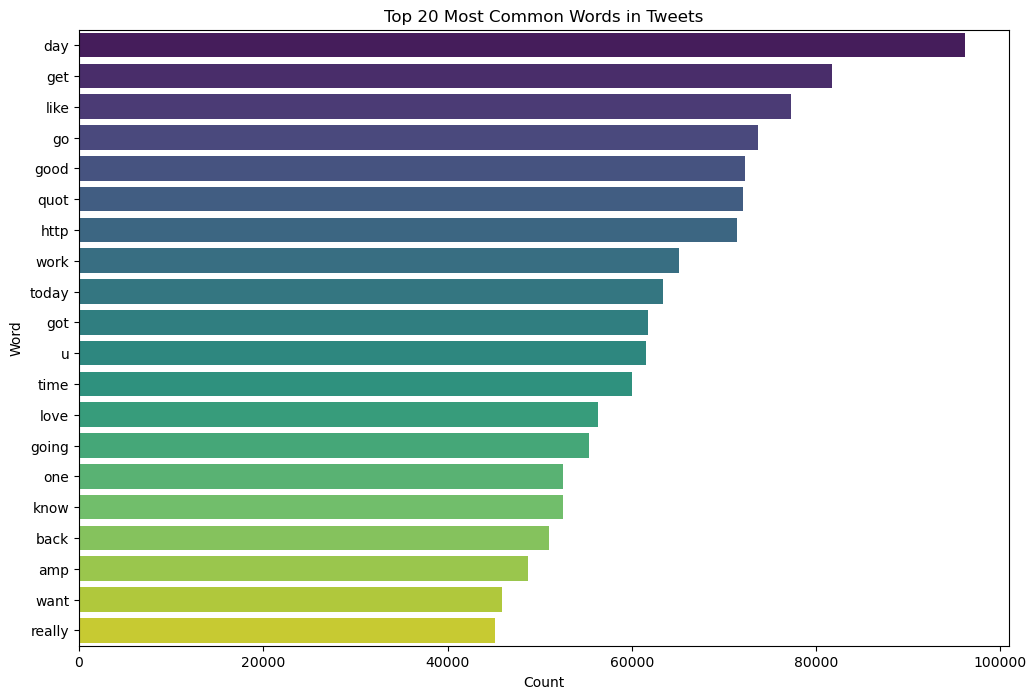

In [36]:
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')
plt.title('Top 20 Most Common Words in Tweets')
plt.show()


### Train the Naive Bayes model

In [37]:
# Spilliting the given data into test and training set and training the model
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)
vectorizer = CountVectorizer()
# Vectorizing of X_train and X_test to convert the documented data to matrix form with the cofficients ,which can be used by ML model
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

### Predictions and evaluation

In [40]:
# Predictions and evaluation
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7705741507145626
              precision    recall  f1-score   support

           0       0.76      0.79      0.78    159265
           4       0.79      0.75      0.77    160651

    accuracy                           0.77    319916
   macro avg       0.77      0.77      0.77    319916
weighted avg       0.77      0.77      0.77    319916

[[126537  32728]
 [ 40669 119982]]


### Logistic Regression model

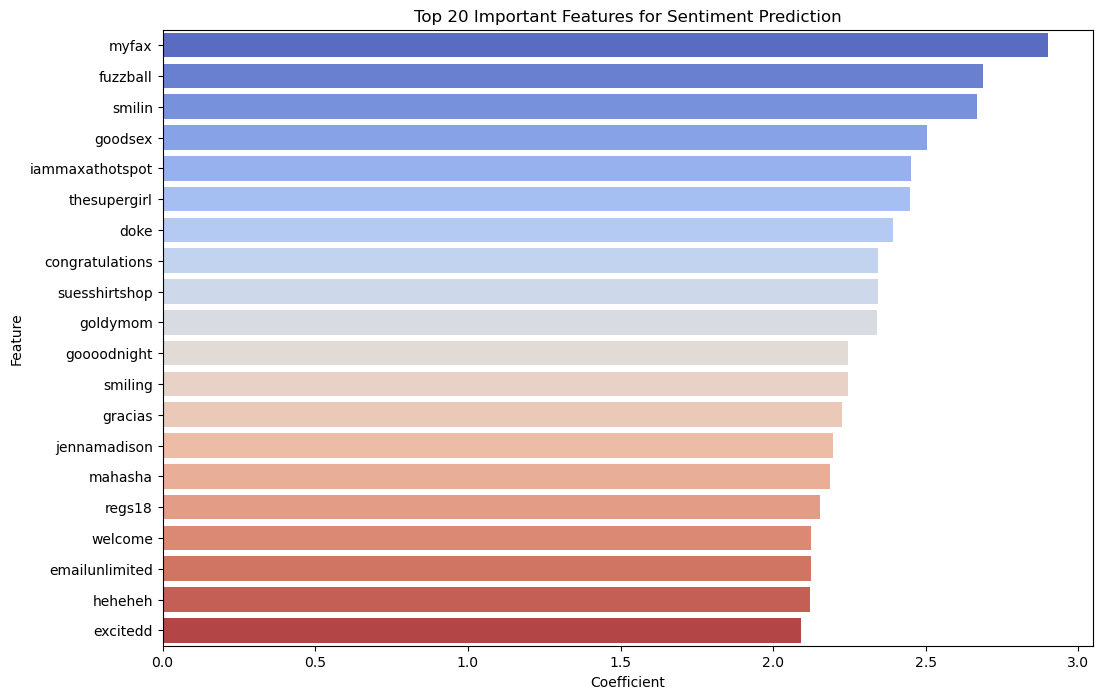

In [41]:
# Training a Logistic Regression model with increased max_iter
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_vec, y_train)


feature_names = vectorizer.get_feature_names_out()
coefficients = logreg_model.coef_[0]

# Create a DataFrame to store feature names and coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

# Visualize the top 20 features based on their coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(20), palette='coolwarm')
plt.title('Top 20 Important Features for Sentiment Prediction')
plt.show()